In [1]:
# 必要なライブラリをインポート
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import lightgbm as lgb

# Colabの場合は以下のコメントアウト外す
from google.colab import drive
drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）

# Google Colabの場合
d_train = pd.read_csv("drive/My Drive/data/train.csv") # 訓練データを読み込む．
d_test = pd.read_csv("drive/My Drive/data/test.csv") # テストデータを読み込む．
# Jupyter Note の場合
#d_train = pd.read_csv("data/train.csv") # 訓練データを読み込む
#d_test = pd.read_csv("data/test.csv") # テストデータを読み込む

print("訓練データとテストデータの数を取得")
n_train = len(d_train)
n_test = len(d_test)
print(f"訓練データ数：{n_train}，テストデータ数：{n_test}")

# targetの値
y_train = d_train.pop('AveragePrice')
y_train = y_train.values # numpyのarrayに変換
print(y_train)

# すべての売り上げ量を足して特徴量として追加
d_train["sum"] = d_train["4046"]+d_train["4225"]+d_train["4770"]+d_train["Small Bags"]+d_train["Large Bags"]+d_train["XLarge Bags"]
d_test["sum"] = d_test["4046"]+d_test["4225"]+d_test["4770"]+d_test["Small Bags"]+d_test["Large Bags"]+d_test["XLarge Bags"]
#d_train["small sum"] = d_train["4046"]+d_train["Small Bags"]
#d_train["lerge sum"] = d_train["4225"]+d_train["Large Bags"]
#d_train["xlerge sum"] = d_train["4770"]+d_train["XLarge Bags"]


# 日付列を分解して特徴量として追加
d_train["year"] = pd.to_datetime(d_train["Date"]).dt.year
d_train["month"] = pd.to_datetime(d_train["Date"]).dt.month
d_train["day"] = pd.to_datetime(d_train["Date"]).dt.day
d_train.drop("Date", axis=1, inplace=True)

d_test["year"] = pd.to_datetime(d_test["Date"]).dt.year
d_test["month"] = pd.to_datetime(d_test["Date"]).dt.month
d_test["day"] = pd.to_datetime(d_test["Date"]).dt.day
d_test.drop("Date", axis=1, inplace=True)

# typeを削除
d_train.drop("type", axis=1, inplace=True)
d_test.drop("type", axis=1, inplace=True)

# one-hot encoding
d_train_test = pd.concat([d_train, d_test], axis=0) # 訓練とテストを連結
columns_cat = ["region"] # カテゴリカル変数の列名（"Date"列は日付情報が抽出されているので不要）

d_train_test_onehot = pd.get_dummies(d_train_test, columns=columns_cat) # get_dummiesを使ってone-hotエンコーディング
d_train_onehot = d_train_test_onehot[:n_train] # d_train_test_onehotの訓練データ部分
d_test_onehot = d_train_test_onehot[n_train:] # d_train_test_onehotのテストデータ部分
X_train = d_train_onehot.values # np.arrayに変換
X_test = d_test_onehot.values  # np.arrayに変換

Mounted at /content/drive
訓練データとテストデータの数を取得
訓練データ数：12774，テストデータ数：5475
[0.82 0.89 2.94 ... 1.92 1.86 0.92]


In [ ]:
# データのスケーリング
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 68,
    'learning_rate': 0.017,
    'n_estimators': 10000,
    'min_child_samples': 8,
    'colsample_bytree': 0.75,
    'subsample': 0.60
}

# lightGBMモデルのインスタンスを作成
lgb_model = lgb.LGBMRegressor(**params)

# 交差検証を実行
scores = cross_validate(lgb_model, X_train_scaled, y_train, cv=5,
                        scoring="neg_mean_squared_error",
                        return_train_score=True)

# スコアの表示
print(f"交差検証の5回のテストスコア：{-scores['test_score']}")
print(f"交差検証の平均テストスコア：{-np.mean(scores['test_score'])}")

print(f"交差検証の5回の訓練スコア：{-scores['train_score']}")
print(f"交差検証の平均訓練スコア：{-np.mean(scores['train_score'])}")

交差検証の5回のテストスコア：[0.0115401  0.01176767 0.01184189 0.01188315 0.01131502]
交差検証の平均テストスコア：0.011669565579822832
交差検証の5回の訓練スコア：[9.85017343e-06 1.07500580e-05 9.79886445e-06 9.84926784e-06
 9.74715186e-06]
交差検証の平均訓練スコア：9.999103112205908e-06


Best Parameters: {'learning_rate': 0.05, 'n_estimators': 1500, 'num_leaves': 60}
Best Score: 0.012208569532439739


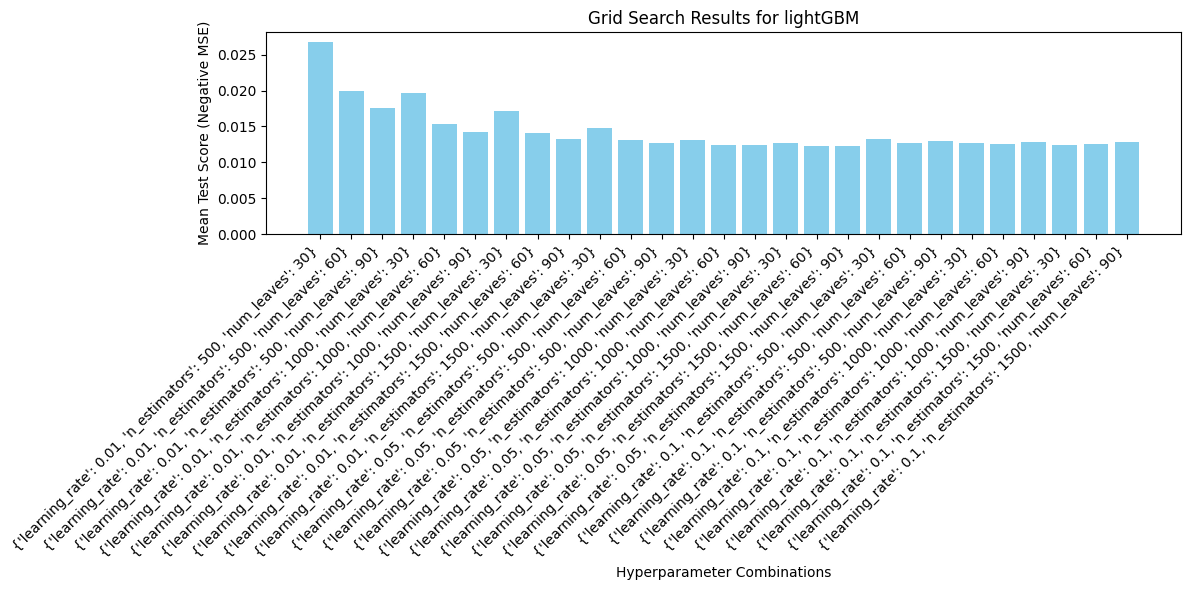

In [2]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# データのスケーリング
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ハイパーパラメータのグリッド
param_grid = {
    'num_leaves': [30, 60, 90],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500],
}

# lightGBMモデルのインスタンスを作成
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression')

# グリッドサーチを実行
grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# グリッドサーチ結果の表示
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# グラフで結果を可視化
mean_test_scores = -grid_search.cv_results_['mean_test_score']
parameter_combinations = [str(param) for param in grid_search.cv_results_['params']]

plt.figure(figsize=(12, 6))
x = np.arange(len(parameter_combinations))
plt.bar(x, mean_test_scores, color='skyblue')
plt.xlabel('Hyperparameter Combinations')
plt.ylabel('Mean Test Score (Negative MSE)')
plt.title('Grid Search Results for lightGBM')
plt.xticks(x, parameter_combinations, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# モデルの訓練
lgb_model.fit(X_train_scaled, y_train)

# テストデータの予測
y_pred_test = lgb_model.predict(X_test_scaled)

# 予測結果をCSVファイルに保存
np.savetxt(fname='y_pred_test_0.01118.csv', X=y_pred_test, delimiter=',')